### Imports

In [3]:
import importlib
import helper, consts
importlib.reload(consts)
importlib.reload(helper)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [4]:
FILEPATH = "/Users/hoangchu/Downloads/Clinic/Clinic/data/hmc/hmc2021/hmc2015/"

In [5]:
def distribution_plot(df, columns, bins):
    
    def plot(column):
        plt.figure(figsize=(8, 6))
        plt.hist(df[column].dropna(), bins=bins, 
                    color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f'Distribution Plot for {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()
        
    for column in columns:
        plot(column)

# Train Data

In [6]:
data = helper.Data(train_data_path=FILEPATH)
orig_df = data.update_and_get_train_df("20150121", backward_dayCount = 1, train_data_count = 100)
df = orig_df.copy()

Getting files from 2014-10-12 00:00:00 to 2015-01-20 00:00:00, inclusive.
Filtered File Dates: ['data.20150102_1200', 'data.20150105_1200', 'data.20150106_1200', 'data.20150107_1200', 'data.20150108_1200', 'data.20150109_1200', 'data.20150112_1200', 'data.20150113_1200', 'data.20150114_1200', 'data.20150115_1200', 'data.20150116_1200', 'data.20150120_1200']



### EDA

#### Machine

In [7]:
def removed_massive_null(df, percentage, can_print = False) -> 'DataFrame':
    null_percents = df.isnull().mean() * 100
    removed_cols = null_percents[null_percents > percentage].index
    
    if can_print: print(f"Massive Null Cols: {removed_cols.tolist()}")
    return df.drop(removed_cols, inplace=False, axis = 1)

df = removed_massive_null(df, 20)

In [8]:
def filter_duplicatations(df, axis: int) -> 'DataFrame':
    use_df = df if axis == 0 else df.T
    answer_df = use_df.drop_duplicates()
    return answer_df if axis == 0 else answer_df.T

df = filter_duplicatations(df, axis = consts.COL)

In [9]:
def transform_col(df, col_name: str, transform_func: 'Function') -> None:
    df.loc[:, col_name] = df[col_name].apply(transform_func); return
    
transform_col(df, consts.RESPONSE_NAME, lambda x: 1 if x > 0 else -1)

In [10]:
def is_responseVal_unbalanced(df: 'DataFrame', response_col_name: str) -> bool:
    freq_map: dict = df[response_col_name].value_counts().to_dict()
    print(freq_map)
    sorted_by_val_keys = sorted(freq_map, key = freq_map.get, reverse = True)
    
    total_count = sum(freq_map.values()); major_val_count = 0
    for key in sorted_by_val_keys:
        major_val_count += freq_map[key]
        if major_val_count > 0.5 * total_count: break
    
    distribution_plot(df, [consts.RESPONSE_NAME], bins = 10)
    return major_val_count >= 0.7 * total_count

{-1.0: 15098, 1.0: 12763}


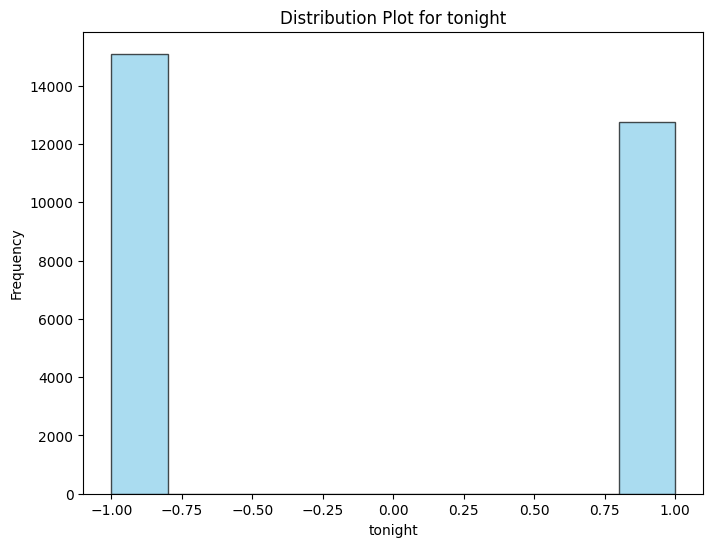

False

In [11]:
is_data_unbalanced = is_responseVal_unbalanced(df, consts.RESPONSE_NAME)
is_data_unbalanced

#### Human

In [12]:
categorical_columns = (df.dtypes == "object")
categorical_columns = np.array(categorical_columns[categorical_columns].index)
len(categorical_columns)

0

In [13]:
df.dtypes.value_counts()

float64    246
Name: count, dtype: int64

# Test Data

#### Make sure test data has similar features to train data

In [15]:
test_df = data.update_and_get_test_df(data_path=FILEPATH, start_date="20150121")[0]
test_df = test_df[df.columns] # TODO: THIS IS VERY IMPORTANT
transform_col(test_df, consts.RESPONSE_NAME, lambda x: 1 if x > 0 else -1)

Getting files from 2015-01-21 00:00:00 to 2015-01-21 00:00:00, inclusive.
Filtered File Dates: ['data.20150121_1200']



# Save

In [16]:
def save_to_csv(df, name, is_train = True):
    directory = "train_data" if is_train else "test_data"
    df.to_csv(f"/Users/hoangchu/Downloads/Clinic/Clinic/data/cleaned_data/{directory}/{name}.csv", index = False)

In [17]:
save_to_csv(df, "train")
save_to_csv(test_df, "test", False)